# Artificial Neural Network for Predicting the Global Mean Forced Response

by Emily M. Gordon

In this notebook, we are going to train an artificial neural network (ANN) to predict the global mean forced response in 2 m temperature (tas). This notebook is meant to follow pretty closely to the excellent notebook on Partial Least Squares (PLS) regression, with the aim of showing how these methods build up from the same principles around preprocessing/training/validating/testing models.

## Some setup notes

This set up is identical to that of partial least squares, except we also need to install tensorflow to make our neural networks which is a line of code added after activating the environment. We also must specify python 3.9 for tensorflow. Below are the steps I (Emily) used to make this environment because I ran into some trouble installing all packages at once with the python version but that might just have been a me problem.

This setup assumes that you have anaconda installed. If you do not, you can install miniconda (from [here](https://docs.conda.io/en/main/miniconda.html)).

To create this environment I ran 

* `conda create -n forcesmip python=3.9`
* `conda activate forcesmip`
* `conda install -c conda-forge xcdat xesmf scikit-learn scipy eofs matplotlib cartopy nc-time-axis ipython ipykernel`
* `pip install tensorflow`
* `python -m ipykernel install --user --name forcesmip --display-name forcesmip`

> Note: You may need to check your shell activate conda. To determine your shell, you can run `echo $SHELL`. You can then activate conda (based on your shell type, e.g., `conda init bash`). 

If you're on Casper/Cheyenne and it won't even let you run conda commands, start with a cheeky `module load conda`

### Import packages

In [1]:
# I/O / data wrangling
import glob
import re
import numpy as np
import xcdat as xc
import xarray as xr
import gc

# runtime metrics
import time as clocktime

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# tensorflow for ANN
import tensorflow as tf

# define a lambda function to perform natural sort
natsort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split("(\d+)", s)]

2023-08-30 11:20:37.190791: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-30 11:20:37.459254: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Define some static mappings for CMIP/ForceSMIP data

This is just some helper information to helps us search for data and reshape it. All ForceSMIP data is on a 2.5 x 2.5 degree lat/lon grid. 

In [2]:
cmipTable = {
    "pr": "Amon",
    "psl": "Amon",
    "tas": "Amon",
    "zmta": "Amon",
    "tos": "Omon",
    "siconc": "OImon",
    "monmaxpr": "Aday",
    "monmaxtasmax": "Aday",
    "monmintasmin": "Aday",
}
cmipVar = {
    "pr": "pr",
    "psl": "psl",
    "tas": "tas",
    "zmta": "ta",
    "tos": "tos",
    "siconc": "siconc",
    "monmaxpr": "pr",
    "monmaxtasmax": "tasmax",
    "monmintasmin": "tasmin",
}
evalPeriods = {
    "Tier1": ("1950-01-01", "2022-12-31"),
    "Tier2": ("1900-01-01", "2022-12-31"),
    "Tier3": ("1979-01-01", "2022-12-31"),
}
nlat = 72
nlon = 144

### Define user-specified parameters

In [3]:
root_dir = "/glade/campaign/cgd/cas/asphilli/ForceSMIP/"  # where is the data on the machine you're using
n_members = 10  # number of members for training
ncvar = "tas" # variable to be used: pr, psl, tas, zmta, tos, siconc, monmaxpr, monmaxtasmax, monmintasmin
reference_period = ("1950-01-01", "1999-12-31") # climatological period (for anomaly calculations)
# choose models for training / validation
# choices include: 'CESM2', 'CanESM5', 'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-LR'
training_models = ["CESM2", "CanESM5", "MIROC6", "MPI-ESM1-2-LR"]
testing_models = ["MIROC-ES2L"]
# choose evaluation data
eval_tier = "Tier1"  # Tier1, Tier2, or Tier3
tv_time_period = evalPeriods[eval_tier]  # populates based on the evaluation data tier, but can be overwritten (with a tuple of date strings)

### Define a function to read in data

We're going to loop over many models and realizations for a) training, b) validation, and c) evaluation data. To make this more readable and to reduce repeating code, we are going to define a function to do this operation.

In [4]:
def load_realization(fn, vid, time_period, reference_period):
    """
    load_realization(fn, vid, time_period, reference_period)
    
    Function loads in data for a given file, fn, and variable, vid. It
    selects data for a given time_period and calculates the annual anomalies
    relative to a user-defined reference_period. The function returns the 3D
    anomaly map, and the global mean time series. 
    
    Inputs:
    -------
    fn (str) : filename
    vid (str) : variable id
    time_period (tuple(str, str)) : tuple of the start and end of the time period
                                    e.g., ("1900-01-01", "1949-12-31")
    reference_period (tuple(str, str)) : tuple of the start and end of the reference period
                                         used to calculate anomalies e.g., ("1900-01-01", "1949-12-31")
                                         
    Returns:
    --------
    ts_3d (xr.DataArray) : annual average anomaly values [time, lat, lon]
    ts_gm (xr.DataArray) : annual average, global mean anomaly values
    """
    # open dataset
    ds = xc.open_dataset(fn)
    # if specified, subset training/validation data to specific period
    if tv_time_period is not None:
        ds = ds.sel(time=slice(time_period[0], time_period[1]))
    # get departures
    ds = ds.temporal.departures(vid, freq="month", reference_period=reference_period)
    # take annual average
    # Note: xcdat takes the annual average ignoring NaN values
    ds = ds.temporal.group_average(vid, freq="year", weighted=False)
    ts_3d = ds[vid]
    # take spatial average
    ds = ds.spatial.average(vid)
    ts_gm = ds[vid]
    # clean up 
    ds.close()
    # return values
    return ts_3d, ts_gm

### Read in evaluation data

We start with the evaluation data, because this data includes observations...and missing data. We will load the evaluation data and create a missing data mask, which we will apply to the training/evaluation data as well. That way the training and evaluation data will be consistent. We store data in a nested dictionary (with the model names as keys). 

*Important note*: we use annual averages in this notebook (which hides missing monthly values). A better method would be to mask at the monthly timescale. 

In [5]:
# first we search for the evaluation data
epath = "/".join([root_dir, "Evaluation-" + eval_tier, cmipTable[ncvar], ncvar])
efiles = glob.glob(epath + "/*.nc")
efiles = sorted(efiles, key=natsort)

# initialize dictionary to store data
evaluation_annual_anomaly_maps = {}
vid = cmipVar[ncvar]

# loop over evaluation files
for im, fn in enumerate(efiles):
    # get evaluation identifier
    model = fn.split("/")[-1].split("_")[2].split(".")[0]
    # print progress
    print(str(im + 1) + " / " + str(len(efiles)) + ": " + model)
    # read in data for realization
    ts_3d, ts_gm = load_realization(fn, vid, tv_time_period, reference_period)
    # store anomaly map
    evaluation_annual_anomaly_maps[model] = ts_3d
    
# create mask for missing data
missing_data_mask = np.mean(ts_3d, axis=0)
missing_data_mask = np.where(np.isnan(missing_data_mask), np.nan, 1)

1 / 10: 1A
2 / 10: 1B
3 / 10: 1C
4 / 10: 1D
5 / 10: 1E
6 / 10: 1F
7 / 10: 1G
8 / 10: 1H
9 / 10: 1I
10 / 10: 1J


### Loop over models and retrieve global mean time series and anomaly maps

We store data in a nested dictionary (with the model and member names as keys). 

In [6]:
# initialize dictionary to store data
global_mean_timeseries = {}
annual_anomaly_maps = {}
vid = cmipVar[ncvar]
# loop over models
models = training_models + testing_models
for im, model in enumerate(models):
    # start timer
    stime = clocktime.time()
    # initialize nested dictionary for model data
    global_mean_timeseries[model] = {}
    annual_anomaly_maps[model] = {}
    # get model files
    mpath = "/".join([root_dir, "Training", cmipTable[ncvar], ncvar, model])
    mfiles = glob.glob(mpath + "/*.nc")
    # parse file names to get list of model members
    # CESM2 has a non-CMIP naming convention
    if model == "CESM2":
        members = [p.split("ssp370_")[-1].split(".1880")[0] for p in mfiles]
    else:
        members = [p.split("_")[-1].split(".")[0] for p in mfiles]
    members = sorted(members, key=natsort)
    # print progress
    print(str(im + 1) + " / " + str(len(models)) + ": " + model + " (" + str(len(members)) + " members)")
    # loop over model members
    for imm, member in enumerate(members):
        # define member filename
        fn = glob.glob(mpath + "/*_" + member + ".*.nc")
        # make sure filename is unique
        if len(fn) != 1:
            raise ValueError("Unexpected number of model members")
        else:
            fn = fn[0]
        # load data for realization
        ts_3d, ts_gm = load_realization(fn, vid, tv_time_period, reference_period)
        # store first N+1 anomaly maps from training models [we keep one extra to inspect skill]
        # also store all data for the validation models
        if ((imm <= n_members) & (model in training_models)) | (model in testing_models):
            # mask missing data
            aam = ts_3d * np.tile(
                np.expand_dims(missing_data_mask, axis=0), (ts_3d.shape[0], 1, 1)
            )
            # store masked data in array
            annual_anomaly_maps[model][member] = aam
        # save global mean time series for all model members
        global_mean_timeseries[model][member] = ts_gm
        # update progress
        print(".", end="")
    # print time elapse for model
    etime = clocktime.time()
    print()
    print("Time elapsed: " + str(etime - stime) + " seconds")
    print()

1 / 5: CESM2 (50 members)
..................................................
Time elapsed: 47.77634072303772 seconds

2 / 5: CanESM5 (25 members)
.........................
Time elapsed: 25.45496702194214 seconds

3 / 5: MIROC6 (50 members)
..................................................
Time elapsed: 63.81628727912903 seconds

4 / 5: MPI-ESM1-2-LR (30 members)
..............................
Time elapsed: 35.679171085357666 seconds

5 / 5: MIROC-ES2L (30 members)
..............................
Time elapsed: 34.59587836265564 seconds



### Calculate the global/ensemble mean forced response 

Here we gather all of the data for a given model ensemble and then compute the ensemble mean time series

In [7]:
# initialize dictionary to hold forced response time series
forced_global_mean_timeseries = {}
# loop over models
for model in models:
    # get model members
    members = global_mean_timeseries[model].keys()
    # initialize list to hold time series for all members
    mgmts = []
    # loop over members
    for member in members:
        # add member time series to list
        ts = global_mean_timeseries[model][member]
        mgmts.append(ts)
    # add ensemble mean time series to dictionary
    da = xr.concat(mgmts, dim='ensemble')
    forced_global_mean_timeseries[model] = da.mean(dim='ensemble')

### Show forced and (example) unforced time series

Just plot the data as a sanity check. 

Text(0, 0.5, 'Unforced GMST')

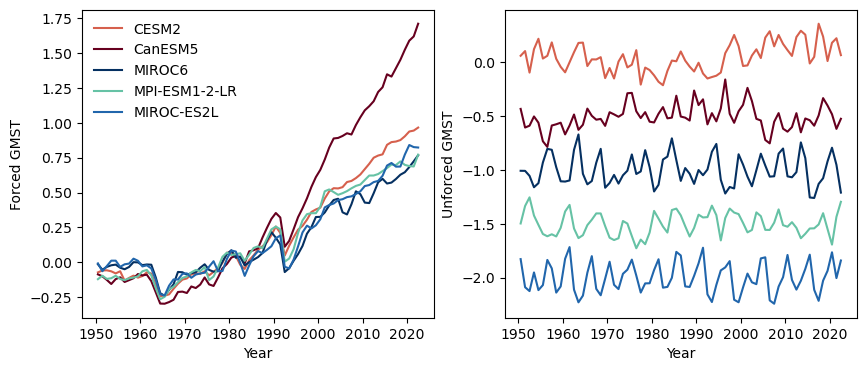

In [8]:
# define some model colors (loosely sorted based on ECS, blue to red)
modelColors = {
    "CESM2": "#d6604d",
    "CanESM5": "#67001f",
    "MIROC-ES2L": "#2166ac",
    "MIROC6": "#053061",
    "MPI-ESM1-2-LR": "#66c2a5",
}
# create figure
plt.figure(figsize=(10, 4))
# loop over models
for im, model in enumerate(models):
    # get and plot forced time series
    tsf = forced_global_mean_timeseries[model]
    time = [t.year + 0.5 for t in tsf.time.values]
    plt.subplot(1, 2, 1)
    plt.plot(time, tsf, color=modelColors[model], label=model)
    # get and plot unforced time series (for one member)
    plt.subplot(1, 2, 2)
    member1 = list(global_mean_timeseries[model].keys())[0]
    tsu = global_mean_timeseries[model][member1] - tsf
    plt.plot(time, tsu - im * 0.5, color=modelColors[model], label=model)
# legend / labels
plt.subplot(1, 2, 1)
plt.legend(loc="upper left", frameon=False)
plt.xlabel("Year")
plt.ylabel("Forced GMST")
plt.subplot(1, 2, 2)
plt.xlabel("Year")
plt.ylabel("Unforced GMST")

### Create predictor / predictand matrices

The predictor matrix, **X**, is of the form `[nsamples, nfeatures]` where the number of samples is the product of the number of climate models used in the training dataset, the number of ensemble members considered, and the length of the time series. The number of features is the number of spatial points (`lat` x `lon`), 10368. The predictand matrix, Y, is of the form `[nsamples, 2]`. The number of the samples is the same as the predictor matrix. There are two columns because we are predicting the forced and unforced component of the time series. 

In [9]:
# initialize X/Y matrices
n_models = len(training_models)
n_timesteps = len(global_mean_timeseries[model][member])
nsamples = n_models * n_members * n_timesteps
nfeatures = nlat * nlon
X = np.zeros((nsamples, nfeatures)) * np.nan
Y = np.zeros((nsamples, 2)) * np.nan
validation_members = {}

# populate matrices
imember = 0  # counting variable
# loop over models
for model in training_models:
    # get members for training and validation
    members = list(annual_anomaly_maps[model].keys())
    # we will consider the last member as the validation member
    validation_members[model] = members[-1]
    # retrieve forced time series (calculated above)
    gmf = np.array(forced_global_mean_timeseries[model])
    # loop over first n_members
    for member in members[0:n_members]:
        # retrieve full [time, lat, lon] time series for X matrix
        # note that data is transformed to [time, space]
        xmaps = np.array(annual_anomaly_maps[model][member])
        xmaps = np.reshape(xmaps, (n_timesteps, -1))
        # add full time series to X matrix
        X[imember * n_timesteps : imember * n_timesteps + n_timesteps, :] = xmaps
        # compute unforced time series
        gmu = np.array(global_mean_timeseries[model][member]) - gmf
        # add forced and unforced global mean time series to Y matrix
        Y[imember * n_timesteps : imember * n_timesteps + n_timesteps, 0] = gmu
        Y[imember * n_timesteps : imember * n_timesteps + n_timesteps, 1] = gmf
        imember += 1  # increment counting variable

# handle missing data
XY_DATA = np.where(~np.isnan(X[0]))[0]  # indices where valid data exists
X = X[:, XY_DATA]

### Normalize matrices

It is standard practice to normalize the predictor / predictand matrix so that the mean is zero and the standard deviation is one (at all spatial points). 

In [10]:
# compute X/Y mean / standard deviation
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
Y_mean = np.mean(Y, axis=0)
Y_std = np.std(Y, axis=0)
# normalize
X = (X - X_mean) / X_std
Y = (Y - Y_mean) / Y_std

### Make the validation data
We are going to make the validation data here because we are going to use it for model selection. When training a neural network, we have the option of including validation data to be evaluated at the end of each pass through the training data or "epoch". The networks performance on the validation data shows us if the model is overfit: if the network is incrementally improving on the training data but not the validation data, it has likely started overfitting. In this case we implement "early stopping" which is when we stop training when the networks perfomance on validation is no longer improving (the loss function for the validation data stops decreasing). 

In [11]:
# make validation data here so can be used in ANN training + early stopping

XV = np.empty((n_models*n_timesteps,nfeatures))+np.nan
YV = np.empty((n_models*n_timesteps,2))+np.nan

predicted_global_mean_timeseries = {}
for imodel, model in enumerate(training_models):
    # get validation members
    member = validation_members[model]
    # loop over members and gather all predictor maps
    xmaps = np.array(annual_anomaly_maps[model][member])
    XV[imodel*n_timesteps:(imodel+1)*n_timesteps,:] = np.reshape(xmaps, (n_timesteps, -1))
    
    gmf = forced_global_mean_timeseries[model]
    gmu = global_mean_timeseries[model][member] - gmf
    YV[imodel*n_timesteps:(imodel+1)*n_timesteps,0] = gmu
    YV[imodel*n_timesteps:(imodel+1)*n_timesteps,1] = gmf
    
# remove missing data
XV = XV[:, XY_DATA]
# normalize
XV = (XV - X_mean) / X_std
YV = (YV - Y_mean) / Y_std

### Build and fit the ANN

In [12]:
# specify hyperparameters and architecture
hiddens = [8,4] # hidden layers in the ANN, as a list e.g. [8,4] means two hidden layers, 8 nodes connected to 4 nodes
l2 = 0.001 # l2/ridge parameter, stops weights becoming too large on the layer its applied to
dfrac = 0.3 # dropout fraction between hidden layers, 30% of connections are dropped during each batch
batchsize = 128 # size of batch to compute loss
nepochs = 1000 # total passes through data
lr = 0.0001 # learning rate
noutputs = 2 # n outputs, one for unforced prediction and one for forced prediction

# build the ANN by adding layers
inputs = tf.keras.Input(shape=(nfeatures,)) # input layers
x = tf.keras.layers.Dense(hiddens[0],
                          activation='relu', # first hidden layer connected to input layer
                          activity_regularizer=tf.keras.regularizers.l2(l2))(inputs)

for hidden in hiddens[1:]: # keep adding hidden layers
    x = tf.keras.layers.Dropout(dfrac)(x)
    x = tf.keras.layers.Dense(hidden,
                              activation='relu',
                              activity_regularizer=tf.keras.regularizers.l2(0))(x)

outputs = tf.keras.layers.Dense(noutputs,)(x) # output layer connected to the rest of the network

ann = tf.keras.Model(inputs=inputs,outputs=outputs) # create model by pointing inputs to outputs
ann.summary() # print a summary so we can check we did it right

# compile the model with the loss function to minimise during training (here we use MSE)
# also specify Adam optimizer with learning rate and also some metrics to track
ann.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    metrics=[tf.keras.metrics.MeanAbsoluteError()],
)

# early stopping tracks the validation loss
es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50, # if loss doesn't decrease for 50 epochs...
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,#... restore the best weights
        start_from_epoch=0
    )

# fit the model!
history = ann.fit(X, Y, batch_size=batchsize, epochs=nepochs,verbose=0,
                  shuffle=True, validation_data=(XV,YV),callbacks=[es])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10368)]           0         
                                                                 
 dense (Dense)               (None, 8)                 82952     
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 2)                 10        
                                                                 
Total params: 82,998
Trainable params: 82,998
Non-trainable params: 0
_________________________________________________________________


### Plot loss and MAE as a function of epoch
Here we plot loss function throughout the training of the neural network. During the training process, the ANN is trying to adjust the weights and biases to minimize the loss function. So, we can get a feel for how well the training process went by plotting the loss function (here mean squared error) for each epoch. We also plot the loss function for the validation data to see if/when the ANN is overfitting. Since we also specified mean absolute error as a metric to track, we can also plot that for the training and validation data.

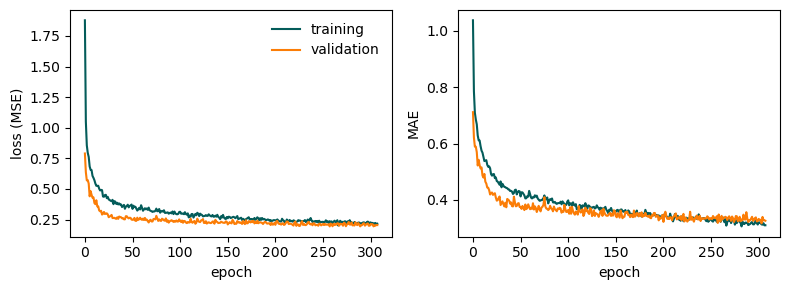

In [13]:
# plot the loss and MAE as a function of epoch
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='training',color='xkcd:dark turquoise')
plt.plot(history.history['val_loss'],label='validation',color='xkcd:pumpkin orange')
plt.xlabel('epoch')
plt.ylabel('loss (MSE)')
plt.legend(loc='upper right', frameon=False)

plt.subplot(1,2,2)
plt.plot(history.history['mean_absolute_error'],color='xkcd:dark turquoise')
plt.plot(history.history['val_mean_absolute_error'],color='xkcd:pumpkin orange')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()

### Predict forced / unforced global mean time series for validation ensemble members

Simply loop over the training models and use the ANN to predict the forced / unforced component of the time series for the members used for validation.

In [14]:
# loop over models
predicted_global_mean_timeseries = {}
for imodel,model in enumerate(training_models):
    member = validation_members[model]
    predicted_global_mean_timeseries[model] = {}
    # apply ANN to predict forced/unforced components
    YP = ann.predict(XV[imodel*n_timesteps:(imodel+1)*n_timesteps])
    # un-normalize predictand time series
    YP = YP * Y_std + Y_mean
    predicted_global_mean_timeseries[model][member] = YP

3/3 [==============================] - 0s 1ms/step


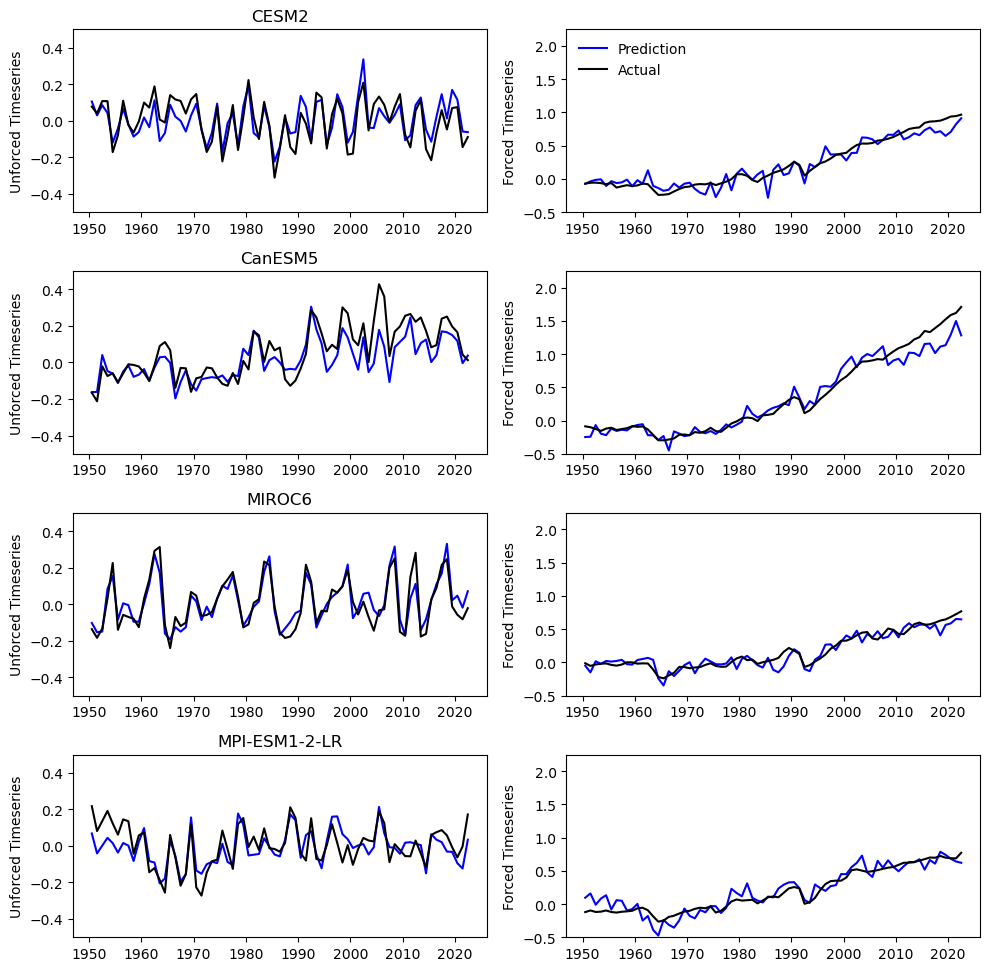

In [15]:
# create figure
plt.figure(figsize=(10, 12))
# loop over training models
for im, model in enumerate(training_models):
    # get evaluation member
    member = validation_members[model]
    # get predicted time series
    YP = predicted_global_mean_timeseries[model][member]
    # get "actual" forced/unforced timeseries
    gmf = forced_global_mean_timeseries[model]
    gmu = global_mean_timeseries[model][member] - gmf
    # plot unforced time series
    plt.subplot(len(models), 2, im * 2 + 1)
    plt.plot(time, YP[:, 0], "b", label="Prediction")
    plt.plot(time, gmu, "k", label="Actual")
    plt.title(model)
    plt.ylim(-0.5, 0.5)
    plt.ylabel("Unforced Timeseries")
    # plot forced time series
    plt.subplot(len(models), 2, im * 2 + 2)
    plt.plot(time, YP[:, 1], "b", label="Prediction")
    plt.plot(time, gmf, "k", label="Actual")
    plt.ylim(-0.5, 2.25)
    plt.ylabel("Forced Timeseries")
    # add legend to upper right plot
    if im == 0:
        plt.legend(loc="upper left", frameon=False)
plt.tight_layout(w_pad=3)

### Predict forced / unforced global mean time series for out-of-sample ensemble *models*

Do the same thing, but for models that were not included in the training dataset. This will be called the testing data.

In [16]:
# loop over testing models
testing_members = {}

for model in testing_models:
    # create empty nested dictionary
    predicted_global_mean_timeseries[model] = {}
    # get members
    members = list(annual_anomaly_maps[model].keys())
    testing_members[model] = members
    # loop over members and gather all predictor maps
    XT = np.zeros((n_timesteps * len(members), nfeatures)) * np.nan
    YT = np.empty((len(members)*n_timesteps,2))+np.nan
    for im, member in enumerate(members):
        xmaps = np.array(annual_anomaly_maps[model][member])
        xt = np.reshape(xmaps, (n_timesteps, -1))
        XT[im * n_timesteps : im * n_timesteps + n_timesteps, :] = xt
        gmf = forced_global_mean_timeseries[model]
        gmu = global_mean_timeseries[model][member] - gmf
        YT[im*n_timesteps:(im+1)*n_timesteps,0] = gmu
        YT[im*n_timesteps:(im+1)*n_timesteps,1] = gmf
    # remove missing data
    XT = XT[:, XY_DATA]
    # normalize
    XT = (XT - X_mean) / X_std
    # apply ANN to predict forced/unforced components (for all members at once)
    YP = ann.predict(XT)
    # un-normalize predictand time series
    YP = YP * Y_std + Y_mean
    # extract data for each member and store in dictionary
    for im, member in enumerate(members):
        predicted_global_mean_timeseries[model][member] = YP[im * n_timesteps : im * n_timesteps + n_timesteps, :]


69/69 [==============================] - 0s 775us/step


### Plot predicted time series for the out-of-sample *model*

This is the same thing as before, except for the testing model(s).

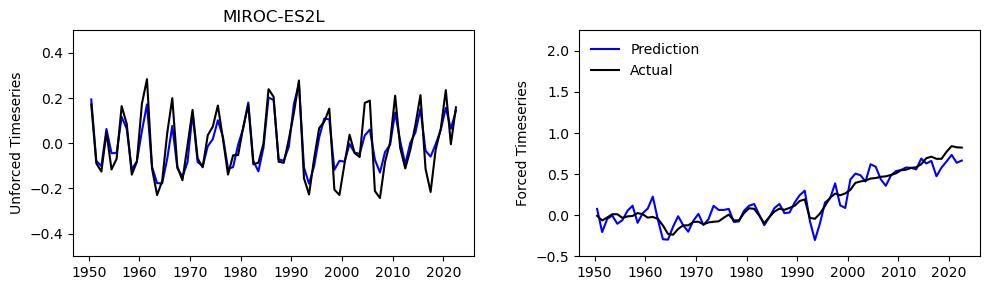

In [17]:
plt.figure(figsize=(10, len(testing_models) * 3))
im = 0
for model in testing_models:
    member = testing_members[model][0] # first member of the testing for plotting
    # get predicted time series
    YP_plot = predicted_global_mean_timeseries[model][member]
    # get "actual" forced/unforced timeseries
    gmf = forced_global_mean_timeseries[model]
    gmu = global_mean_timeseries[model][member] - gmf
    # plot
    plt.subplot(len(testing_models), 2, im * 2 + 1)
    plt.plot(time, YP_plot[:, 0], "b", label="Prediction")
    plt.plot(time, gmu, "k", label="Actual")
    plt.title(model)
    plt.ylim(-0.5, 0.5)
    plt.ylabel("Unforced Timeseries")
    plt.subplot(len(testing_models), 2, im * 2 + 2)
    plt.plot(time, YP_plot[:, 1], "b", label="Prediction")
    plt.plot(time, gmf, "k", label="Actual")
    plt.ylim(-0.5, 2.25)
    plt.ylabel("Forced Timeseries")
    if im == 0:
        plt.legend(loc="upper left", frameon=False)
plt.tight_layout(w_pad=3)

### Interrogate some of the ANN predictions

We are going to look at some explainable AI (XAI) maps to understand which parts of our inputs are important for our ANN's predictions. To start with, we are going to look at an XAI heatmap. Note here I will use a function for input*gradient which is mathematically equivalent to the LRP-Z method when hidden layers have ReLU activation.

The following functions are adapted from Dr. Antonios Mamalakis, and his excellent work on the importance of selecting a baseline prediction when applying XAI techniques [paper here](https://journals.ametsoc.org/view/journals/aies/2/1/AIES-D-22-0058.1.xml).

In [18]:
def get_gradients(inputs, pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        model (tensorflow model): to pull gradients from
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = ann(inputs, training=False)  
        
        # choose which prediction to inspect
        preds = preds[:, pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

def get_input_t_gradient(inputs, baseline=None, pred_idx=None):
    """Computes Input times gradient for a prediction.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        model (tensorflow model): the NN to pull gradients from
        baseline (float): value to compare actual prediction to
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem.         

    Returns:
        Input times gradient w.r.t input image
    
    """
    # If baseline is not provided, start with zeros
    # having same size as the input image.
    if baseline is None:
        input_size = np.shape(inputs)[1:]
        baseline = np.zeros(input_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)
        
    inputs = inputs.astype(np.float32)

    grads = get_gradients(inputs, pred_idx=pred_idx)
    
    input_t_gradient = (inputs-baseline) * grads
    
    return input_t_gradient


## Investigate positive predictions in the unforced timesceries
Starting with a simple example, we are going to examine the XAI heatmaps for moderately extreme positive tas anomaly predictions in the global unforced timeseries. That is, I'm going to examine the heatmaps for the orange dots in the following figure.

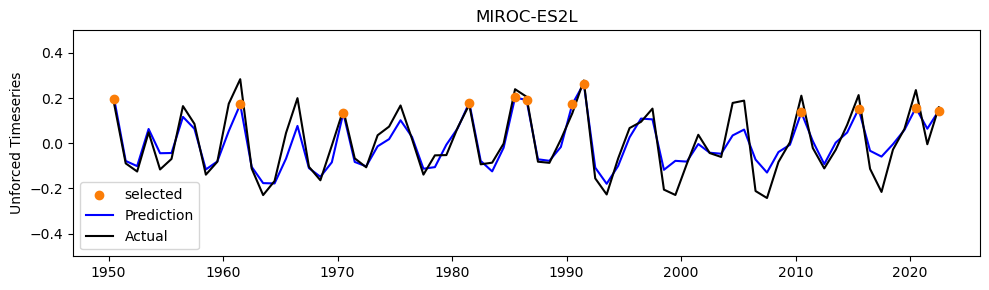

In [19]:
# Plot the predictions that we are going to investigate
YP_sel = 1.*(YP[:,0]>Y_std[0]) # any prediction that is greater than one standard deviation above the mean (0 by construction)
YP_sel[YP_sel==0] = np.nan

plt.figure(figsize=(10, len(testing_models) * 3))
im = 0
for model in testing_models:
    member = testing_members[model][0]
    # get predicted time series
    YP_plot = predicted_global_mean_timeseries[model][member]
    # get "actual" forced/unforced timeseries
    gmf = forced_global_mean_timeseries[model]
    gmu = global_mean_timeseries[model][member] - gmf
    # plot
    plt.scatter(time, YP_plot[:, 0]*YP_sel[:n_timesteps],color="xkcd:pumpkin orange",label="selected",zorder=2)
    plt.plot(time, YP[:n_timesteps,0], color="b", label="Prediction",zorder=0)
    plt.plot(time, gmu, "k", label="Actual",zorder=1)
    plt.title(model)
    plt.legend()
    plt.ylim(-0.5, 0.5)
    plt.ylabel("Unforced Timeseries")

plt.tight_layout(w_pad=3)

### Generate XAI maps

In [20]:
YP_sel = (YP[:,0]>1*Y_std[0])
XT_sel = XT[YP_sel] # inputs corresponding to selected predictions

xaimaps_IG = [] # empty list for our heatmaps

for isamp,samp in enumerate(XT_sel):
    samp=samp[np.newaxis,:] # reshape to correct dimensions
    xaisamp = np.squeeze(get_input_t_gradient(samp,pred_idx=0)) # calculate XAI heatmap
    xaisamp = xaisamp/np.abs(np.nansum(xaisamp)) # normalize by the sum of all relevances
    xaimaps_IG.append(xaisamp) 


### Plot the XAI heatmap for positive anomaly predictions
Plot the tas anomaly for one positive prediction sample, and its corresponding XAI heatmap.

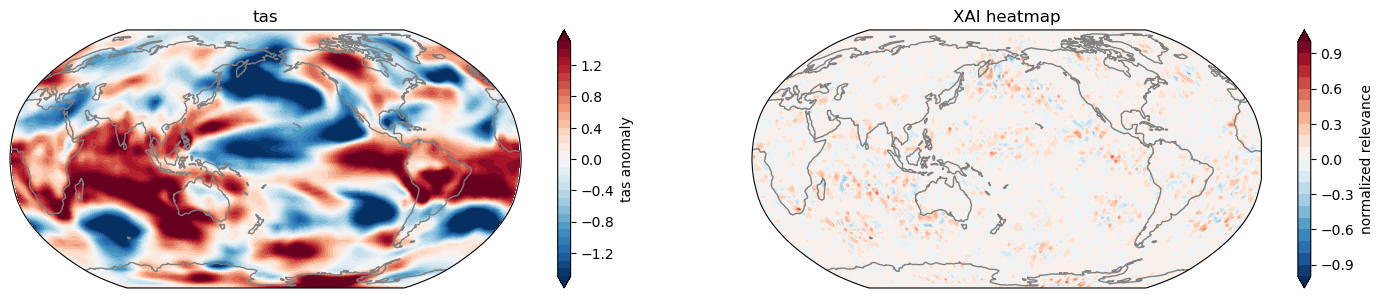

In [21]:
indsel = 3

xaimaps_IG = np.asarray(xaimaps_IG)

lat = annual_anomaly_maps[model][member].lat
lon = annual_anomaly_maps[model][member].lon

Xplot = np.reshape(XT_sel[indsel,:],(nlat,nlon))
xaiplot = np.reshape(xaimaps_IG[indsel,:],(nlat,nlon))
xaiplot = xaiplot/np.max(np.abs(xaiplot))

plt.figure(figsize=(15,3))

a1=plt.subplot(1,2,1,projection=ccrs.Robinson(central_longitude=180))
c1=a1.contourf(lon,lat,Xplot,np.arange(-1.5,1.6,0.1),transform=ccrs.PlateCarree(),cmap='RdBu_r',extend='both')
a1.coastlines(color='gray')
plt.title('tas')
cb1=plt.colorbar(c1)
cb1.ax.set_ylabel('tas anomaly')

a2=plt.subplot(1,2,2,projection=ccrs.Robinson(central_longitude=180))
c2=a2.contourf(lon,lat,xaiplot,np.arange(-1,1.1,0.1),transform=ccrs.PlateCarree(),cmap='RdBu_r',extend='both')
a2.coastlines(color='gray')
plt.title('XAI heatmap')
cb2=plt.colorbar(c2)
cb2.ax.set_ylabel('normalized relevance')

plt.tight_layout()

So, the heatmap is kind of (very) noisy! This is because our data is quite high resolution, so we are looking at relevances for every single 2.5 x 2.5 grid point. We could apply some gaussian smoothing to clean it up a bit, but I think it is important to first look at the raw relevances. Here, the grid points that are most relevant to the neural network's positive unforced anomaly prediction correspond to the most dense regions of red. Do these regions correspond to where we think they should?

## Examining the forced response
In the previous example, we looked at predictions of unforced variability. In particular, we implicitly asked the ANN "what made you predict a positive anomaly when compared to a baseline of climatology" which we did by using a baseline of zeros (climatology by construction). However, using XAI for regression tasks gets a little tricky when we start thinking about things like trends and forcing, because the XAI method compares a prediction to some baseline input. We therefore need to think carefully about what we are actually asking about which will guide how we choose the baseline.

In the next example, we are going to look at errors in the forced response prediction. Here I am going to grab samples with the largest error in the forced timeseries after the year 2000, *and* the ANN underestimated the forcing. The question I will ask is "how did each grid point affect the predicted values when compared to a baseline of the 1950-1980 mean", i.e., the baseline will be the average input for 1950-1980 across all members.


In [22]:
#grab only last 20 years of each member for XAI
ngrab = 20
members = list(annual_anomaly_maps[model].keys())

YP_grab = np.asarray([YP[(imember+1)*n_timesteps-ngrab:(imember+1)*n_timesteps,:] for imember in range(len(members))])
YT_grab = np.asarray([YT[(imember+1)*n_timesteps-ngrab:(imember+1)*n_timesteps,:] for imember in range(len(members))])
XT_grab = np.asarray([XT[(imember+1)*n_timesteps-ngrab:(imember+1)*n_timesteps,:] for imember in range(len(members))])

### Plot the actual vs predicted and also a histogram of the error
This is just a check I like to do to get a feel for the performance of the ANN, and to understand the data that I will be investigating. The samples we are investigating are highlighted in green in the first plot, and are below the green line in the error histogram.

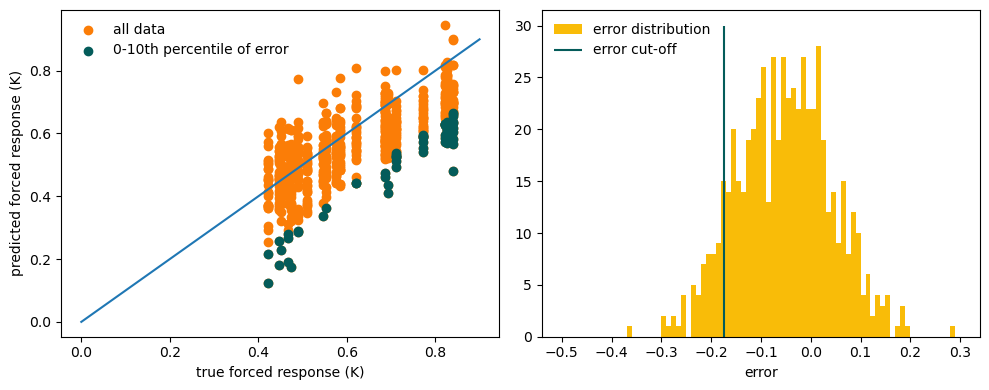

In [23]:
error = YP_grab[:,:,1]-YT_grab[:,:,1] #error in the forcing predictions
error_thres = 10 # our error threshold is the lowest 10% of the error distribution
bad = np.percentile(error,error_thres)
badpred = error<bad # boolean of the predictions we want to examine

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.scatter(YT_grab[:,:,1].flatten(),YP_grab[:,:,1].flatten(),color='xkcd:pumpkin orange',label='all data')
plt.scatter(YT_grab[badpred,1],YP_grab[badpred,1],color='xkcd:dark turquoise',label='0-10th percentile of error')
plt.legend(frameon=False)
plt.xlabel('true forced response (K)')
plt.ylabel('predicted forced response (K)') 
plt.plot(np.arange(0,1,0.1),np.arange(0,1,0.1))

plt.subplot(1,2,2)
plt.hist(error.flatten(),bins=np.arange(-0.5,0.31,0.01),color='xkcd:golden rod',label='error distribution')
plt.vlines(bad,0,30,color='xkcd:dark turquoise',label='error cut-off')
plt.xlabel('error')
plt.legend(frameon=False)
plt.tight_layout()

In [24]:
# make a baseline of first 30 years from each member
nbaseline = 30
XT_baseline = np.asarray([XT[imember*n_timesteps:imember*n_timesteps+nbaseline,:] 
                          for imember in range(len(members))])
XT_baseline = np.mean(XT_baseline,axis=(0,1))

In [25]:
XT_bad = XT_grab[badpred,:] # grab the predictions that we want
xaimaps_IG = []

for isamp,samp in enumerate(XT_bad):
    samp=samp[np.newaxis,:]
    xaisamp = np.squeeze(get_input_t_gradient(samp,baseline=XT_baseline,pred_idx=1))
    xaisamp = xaisamp/np.abs(np.nansum(xaisamp))
    xaimaps_IG.append(xaisamp)


### Plot the composite of the inputs for these samples, and the corresponding composite heatmap

We take the mean across all input samples and all heatmaps to examine signals that are common to the worst underestimates. 

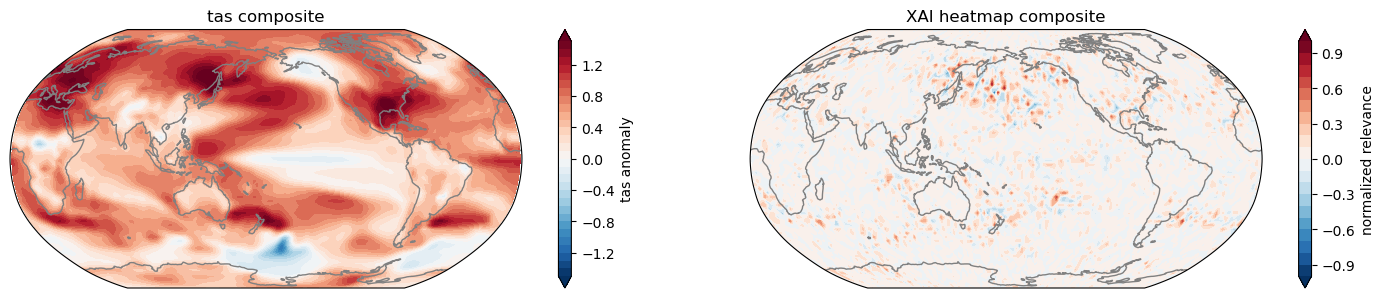

In [26]:
xaimaps_IG = np.asarray(xaimaps_IG)

Xcomposite = np.mean(XT_bad,axis=0)
Xplot = np.reshape(Xcomposite,(nlat,nlon))

xaicomposite = np.mean(xaimaps_IG,axis=0)
xaiplot = np.reshape(xaicomposite,(nlat,nlon))
xaiplot = xaiplot/np.nanmax(np.abs(xaiplot))

plt.figure(figsize=(15,3))

a1=plt.subplot(1,2,1,projection=ccrs.Robinson(central_longitude=180))
c1=a1.contourf(lon,lat,Xplot,np.arange(-1.5,1.6,0.1),transform=ccrs.PlateCarree(),cmap='RdBu_r',extend='both')
a1.coastlines(color='gray')
plt.title('tas composite')
cb1=plt.colorbar(c1)
cb1.ax.set_ylabel('tas anomaly')

a2=plt.subplot(1,2,2,projection=ccrs.Robinson(central_longitude=180))
c2=a2.contourf(lon,lat,xaiplot,np.arange(-1,1.1,0.1),transform=ccrs.PlateCarree(),cmap='RdBu_r',extend='both')
a2.coastlines(color='gray')
plt.title('XAI heatmap composite')
cb2=plt.colorbar(c2)
cb2.ax.set_ylabel('normalized relevance')

plt.tight_layout()

### Plot an individual heatmap

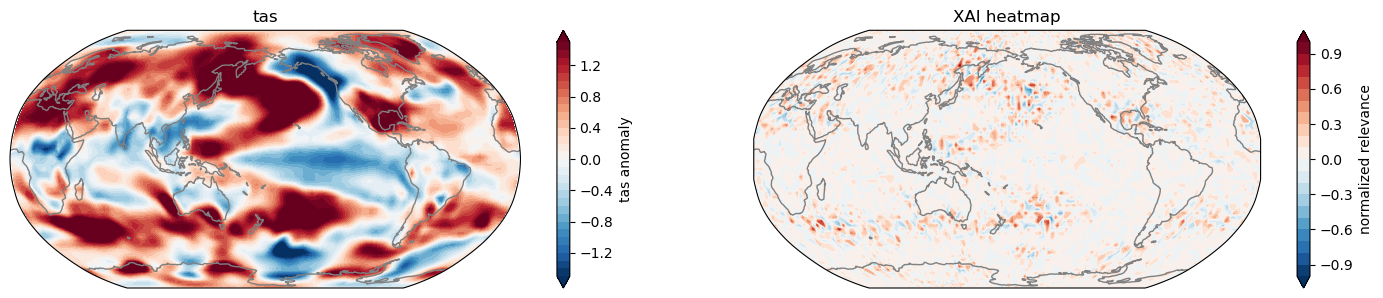

In [27]:
indsel = 0

Xplot = np.reshape(XT_bad[indsel,:],(nlat,nlon))

xaiplot = np.reshape(xaimaps_IG[indsel,:],(nlat,nlon))
xaiplot = xaiplot/np.max(np.abs(xaiplot))

plt.figure(figsize=(15,3))

a1=plt.subplot(1,2,1,projection=ccrs.Robinson(central_longitude=180))
c1=a1.contourf(lon,lat,Xplot,np.arange(-1.5,1.6,0.1),transform=ccrs.PlateCarree(),cmap='RdBu_r',extend='both')
a1.coastlines(color='gray')
plt.title('tas')
cb1=plt.colorbar(c1)
cb1.ax.set_ylabel('tas anomaly')

a2=plt.subplot(1,2,2,projection=ccrs.Robinson(central_longitude=180))
c2=a2.contourf(lon,lat,xaiplot,np.arange(-1,1.1,0.1),transform=ccrs.PlateCarree(),cmap='RdBu_r',extend='both')
a2.coastlines(color='gray')
plt.title('XAI heatmap')
cb2=plt.colorbar(c2)
cb2.ax.set_ylabel('normalized relevance')

plt.tight_layout()

### Apply ANN to Evaluation Data
Let's see how this thing cooks on the evaluation data

In [28]:
evaluation_models = list(evaluation_annual_anomaly_maps.keys())
# loop over models
for model in evaluation_models:
    # get predictor matrix
    xmaps = np.array(evaluation_annual_anomaly_maps[model])
    X_eval = np.reshape(xmaps, (n_timesteps, -1))
    # remove missing data
    X_eval = X_eval[:, XY_DATA]
    # normalize
    X_eval = (X_eval - X_mean) / X_std
    # apply ANN regression to predict forced/unforced components
    YP = ann.predict(X_eval)
    # un-normalize predictand time series
    YP = YP * Y_std + Y_mean
    predicted_global_mean_timeseries[model] = YP

3/3 [==============================] - 0s 1ms/step


### Plot predictions for evaluation time series

Now we apply our ANN model to evaluation data that was not included in training (and we do not know the "true" answer).

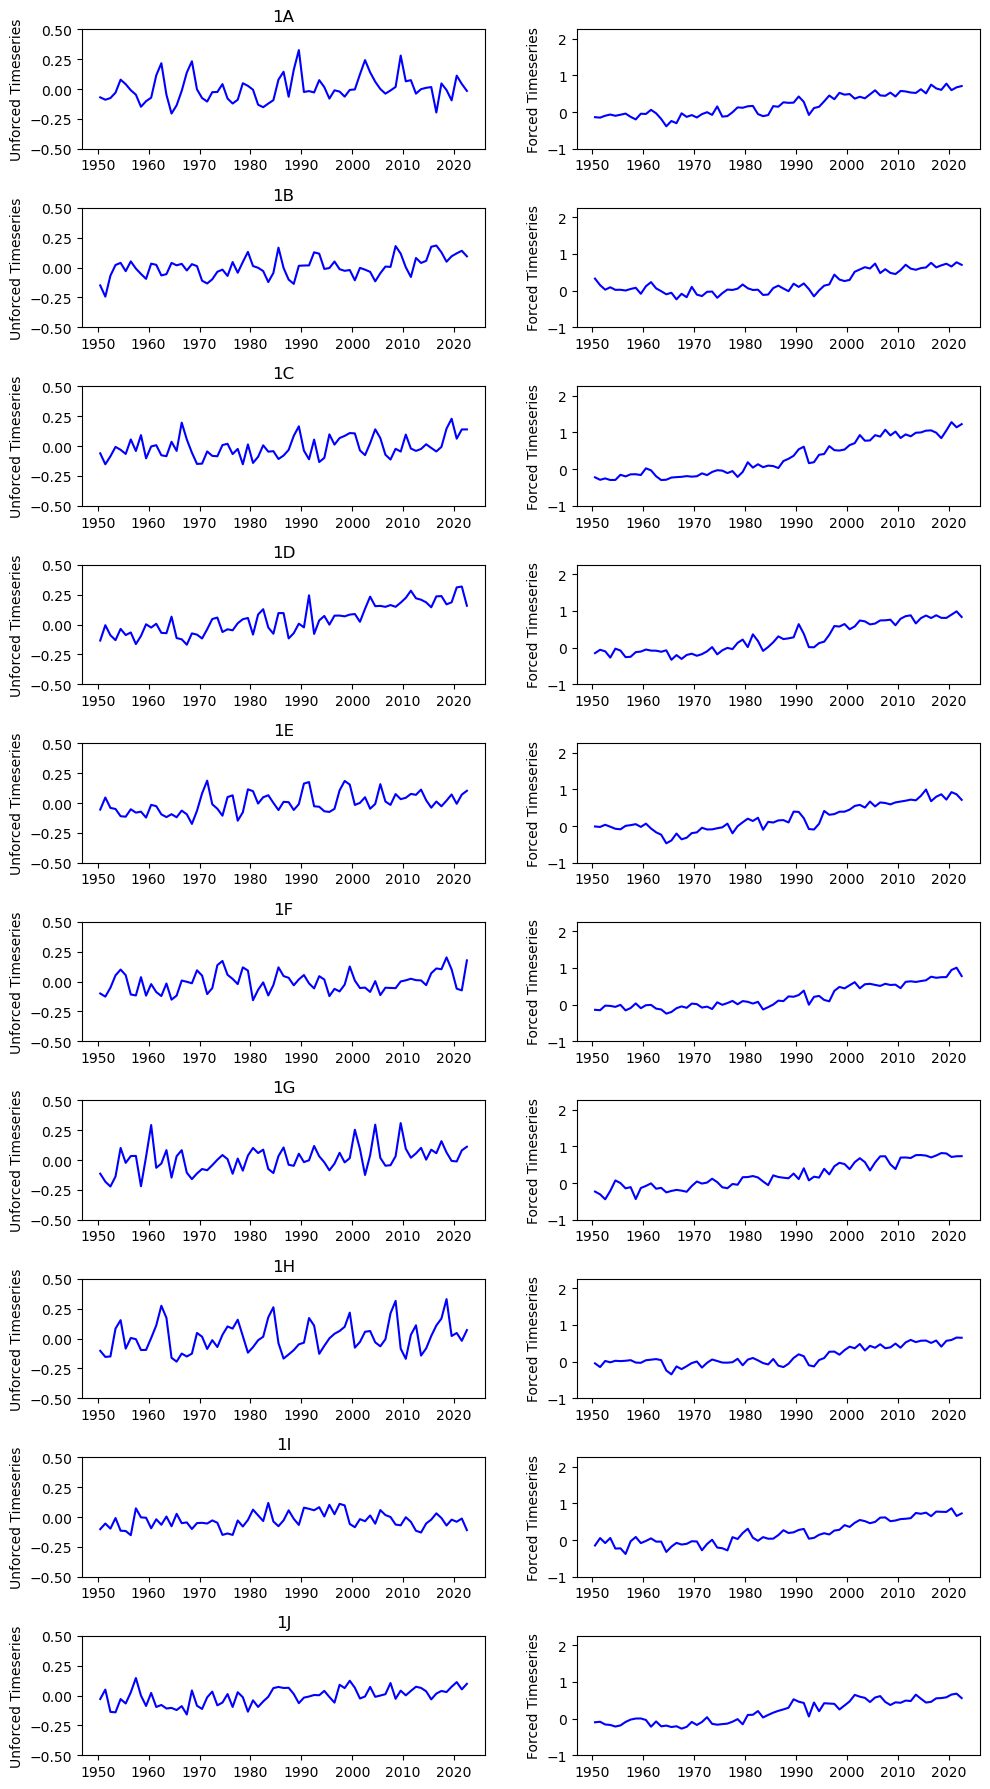

In [29]:
plt.figure(figsize=(10, 18))
for im, model in enumerate(evaluation_models):
    # get predicted time series
    YP = predicted_global_mean_timeseries[model]
    # plot unforced time series
    plt.subplot(len(evaluation_models), 2, im * 2 + 1)
    plt.plot(time, YP[:, 0], "b", label="Prediction")
    plt.title(model)
    plt.ylim(-0.5, 0.5)
    plt.ylabel("Unforced Timeseries")
    # plot forced time series
    plt.subplot(len(evaluation_models), 2, im * 2 + 2)
    plt.plot(time, YP[:, 1], "b", label="Prediction")
    plt.ylim(-1, 2.25)
    plt.ylabel("Forced Timeseries")
plt.tight_layout(w_pad=3)

### Discussion questions

* Try adjusting some parameters in the ANN (I would recommend playing around with hidden layers and l2 to start with). How does this affect the ANN's performance?

* I plotted a composite for the worst underestimates, was this a good idea? Why might we not want to plot composites in this case?

* I subsampled predictions in two different ways (high positive unforced predictions, and worst underestimates after 2000). Are there other ways we could subsample to understand when our neural network is good/bad?

